<a href="https://colab.research.google.com/github/kgpark88/visionai/blob/main/pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자세 추정(Pose Estimation)


### 라이브러리 임포트

In [4]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

### 이미지 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://raw.githubusercontent.com/kgpark88/visionai/main/Lee-Kang-In.jpg

--2023-10-24 15:03:54--  https://raw.githubusercontent.com/kgpark88/visionai/main/Lee-Kang-In.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77669 (76K) [image/jpeg]
Saving to: ‘Lee-Kang-In.jpg’

Lee-Kang-In.jpg     100%[===================>]  75.85K  --.-KB/s    in 0.01s   

2023-10-24 15:03:54 (6.30 MB/s) - ‘Lee-Kang-In.jpg’ saved [77669/77669]



In [5]:
image = cv2.imread('Lee-Kang-In.jpg')

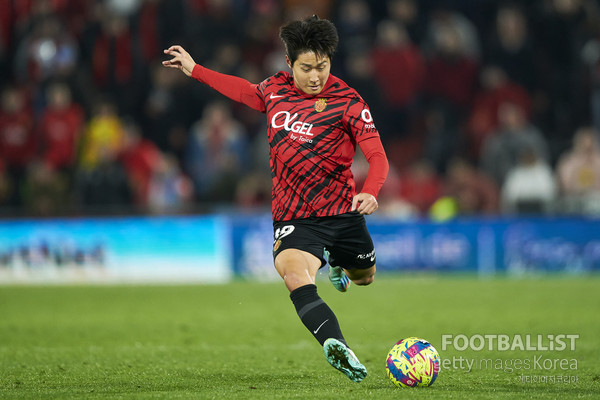

In [6]:
cv2_imshow(image)

In [7]:
image.shape

(400, 600, 3)

In [8]:
type(image)

numpy.ndarray

In [9]:
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0 / 255,
                                   size = (image.shape[1], image.shape[0]))

In [10]:
type(image_blob)

numpy.ndarray

In [11]:
image_blob.shape

(1, 3, 400, 600)

### 사전 학습된 신경망 로드
#### pose_iter_160000.caffemodel 파일 업로드
- https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_160000.caffemodel   

#### Caffe Deep Learning framework: https://caffe.berkeleyvision.org/

In [13]:
!wget https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt

--2023-10-24 15:26:49--  https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32217 (31K) [text/plain]
Saving to: ‘pose_deploy_linevec_faster_4_stages.prototxt’

pose_deploy_linevec 100%[===================>]  31.46K  --.-KB/s    in 0.006s  

2023-10-24 15:26:49 (5.57 MB/s) - ‘pose_deploy_linevec_faster_4_stages.prototxt’ saved [32217/32217]



In [15]:
network = cv2.dnn.readNetFromCaffe('pose_deploy_linevec_faster_4_stages.prototxt',
                                   'pose_iter_160000.caffemodel')

error: ignored

In [ ]:
network.getLayerNames()

('conv1_1',
 'relu1_1',
 'conv1_2',
 'relu1_2',
 'pool1_stage1',
 'conv2_1',
 'relu2_1',
 'conv2_2',
 'relu2_2',
 'pool2_stage1',
 'conv3_1',
 'relu3_1',
 'conv3_2',
 'relu3_2',
 'conv3_3',
 'relu3_3',
 'conv3_4',
 'relu3_4',
 'pool3_stage1',
 'conv4_1',
 'relu4_1',
 'conv4_2',
 'relu4_2',
 'conv4_3_CPM',
 'relu4_3_CPM',
 'conv4_4_CPM',
 'relu4_4_CPM',
 'conv5_1_CPM_L1',
 'relu5_1_CPM_L1',
 'conv5_1_CPM_L2',
 'relu5_1_CPM_L2',
 'conv5_2_CPM_L1',
 'relu5_2_CPM_L1',
 'conv5_2_CPM_L2',
 'relu5_2_CPM_L2',
 'conv5_3_CPM_L1',
 'relu5_3_CPM_L1',
 'conv5_3_CPM_L2',
 'relu5_3_CPM_L2',
 'conv5_4_CPM_L1',
 'relu5_4_CPM_L1',
 'conv5_4_CPM_L2',
 'relu5_4_CPM_L2',
 'conv5_5_CPM_L1',
 'conv5_5_CPM_L2',
 'concat_stage2',
 'Mconv1_stage2_L1',
 'Mrelu1_stage2_L1',
 'Mconv1_stage2_L2',
 'Mrelu1_stage2_L2',
 'Mconv2_stage2_L1',
 'Mrelu2_stage2_L1',
 'Mconv2_stage2_L2',
 'Mrelu2_stage2_L2',
 'Mconv3_stage2_L1',
 'Mrelu3_stage2_L1',
 'Mconv3_stage2_L2',
 'Mrelu3_stage2_L2',
 'Mconv4_stage2_L1',
 'Mrelu4_sta

In [ ]:
len(network.getLayerNames())

127

### 바디 포인트 예측

In [ ]:
network.setInput(image_blob)
output = network.forward()

In [ ]:
# 44 -> related to the points that were detected
# (43, 75) -> information about the location
output.shape

(1, 44, 43, 75)

In [ ]:
position_width = output.shape[3]
position_heigth = output.shape[2]

In [ ]:
position_width

75

In [ ]:
(image.shape[1] * 28) / 75

224.0

In [ ]:
# minMaxLoc: https://docs.opencv.org/master/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
    #print(i)
    confidence_map = output[0, i, :, :]
    #print(confidence_map) # candidate points
    #print(len(confidence_map))
    _, confidence, _, point = cv2.minMaxLoc(confidence_map)
    #print(confidence)
    #print(point)

    x = int((image.shape[1] * point[0]) / position_width)
    y = int((image.shape[0] * point[1]) / position_heigth)
    #print(x,y)
    if confidence > threshold:
        cv2.circle(image, (x, y), 5, (0,255,0), thickness = -1)
        cv2.putText(image, '{}'.format(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255))
        points.append((x,y))
    else:
        points.append(None)

In [ ]:
points

[(224, 23),
 (248, 62),
 (232, 94),
 (208, 125),
 (176, 148),
 (280, 62),
 (320, 39),
 (360, 15),
 (288, 180),
 (320, 250),
 (320, 321),
 (312, 164),
 (336, 250),
 (296, 305),
 (280, 125)]

In [ ]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [ ]:
point_connections = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],[1,14],
                     [14,8], [8,9], [9,10], [14,11], [11,12], [12,13]]

In [ ]:
point_connections

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [ ]:
for connection in point_connections:
    #print(connection)
    partA = connection[0]
    partB = connection[1]
    #print(partA, partB)
    if points[partA] and points[partB]:
        cv2.line(image, points[partA], points[partB], (255,0,0))

In [ ]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## 움직임 감지(팔을 머리 위로 올리기)

In [ ]:
image2 = cv2.imread('player.jpg')
cv2_imshow(image2)

In [ ]:
!wget https://raw.githubusercontent.com/kgpark88/visionai/main/player.jpg

In [16]:
image2 = cv2.imread('player.jpg')
image_blob2 = cv2.dnn.blobFromImage(image = image2, scalefactor = 1.0 / 255, size = (image2.shape[1], image2.shape[0]))
network.setInput(image_blob2)
output2 = network.forward()
position_width = output2.shape[3]
position_height = output2.shape[2]
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
    confidence_map = output2[0, i, :, :]
    _, confidence, _, point = cv2.minMaxLoc(confidence_map)
    x = int((image2.shape[1] * point[0]) / position_width)
    y = int((image2.shape[0] * point[1]) / position_height)

    if confidence > threshold:
        cv2.circle(image2, (x, y), 3, (0,255,0), thickness = -1)
        cv2.putText(image2, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .3, (0, 0, 255))
        cv2.putText(image2, '{}-{}'.format(point[0], point[1]), (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (255,0,255))
        points.append((x, y))
    else:
        points.append(None)

plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB));

AttributeError: ignored

In [ ]:
def verify_arms_up(points):
    head, right_wrist, left_wrist = 0, 0, 0
    for i, point in enumerate(points):
        #print(i, point)
        if i == 0:
            head = point[1]
        elif i == 4:
            right_wrist = point[1]
        elif i == 7:
            left_wrist = point[1]

    #print(head, right_wrist, left_wrist)
    if right_wrist < head and left_wrist < head:
        return True
    else:
        return False

In [ ]:
verify_arms_up(points)

True

In [ ]:
!wget https://raw.githubusercontent.com/kgpark88/visionai/main/jump.jpg

In [ ]:
image = cv2.imread('jump.jpg')
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0 / 255, size = (image.shape[1], image.shape[0]))
network.setInput(image_blob)
output = network.forward()
position_width = output.shape[3]
position_height = output.shape[2]
num_points = 15
points = []
threshold = 0.1
for i in range(num_points):
    confidence_map = output[0, i, :, :]
    _, confidence, _, point = cv2.minMaxLoc(confidence_map)
    x = int((image.shape[1] * point[0]) / position_width)
    y = int((image.shape[0] * point[1]) / position_height)

    if confidence > threshold:
        cv2.circle(image, (x, y), 3, (0,255,0), thickness = -1)
        cv2.putText(image, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .2, (0, 0, 255))
        cv2.putText(image, "{}-{}".format(point[0], point[1]), (x, y + 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 0, 255))
        points.append((x, y))
    else:
        points.append(None)

plt.figure(figsize = [14,10])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [ ]:
def verify_legs_apart(points):
    left_hip, rigth_hip = 0, 0
    left_ankle, right_ankle = 0, 0

    for i, point in enumerate(points):
        if i == 11:
            left_hip = point[0]
        elif i == 8:
            rigth_hip = point[0]
        elif i == 13:
            left_ankle = point[0]
        elif i == 10:
            rigth_ankle = point[0]

    if (left_ankle > left_hip) and (rigth_ankle < rigth_hip):
        return True
    else:
        return False

In [ ]:
verify_legs_apart(points)

True

### 동영상에서 머리 위로 팔 올리기

- VideoWriter_fourcc: https://www.programcreek.com/python/example/89348/cv2.VideoWriter_fourcc

In [ ]:
!wget https://raw.githubusercontent.com/kgpark88/visionai/main/gesture.mp4

In [ ]:
video = 'gesture.mp4'
capture = cv2.VideoCapture(video)
connected, frame = capture.read()

In [ ]:
connected

True

In [ ]:
frame.shape

(1080, 808, 3)

In [ ]:
result = '/content/drive/MyDrive/ComputerVision/video/gesture1_result.mp4'
save_video = cv2.VideoWriter(result, cv2.VideoWriter_fourcc(*'XVID'),  10, (frame.shape[1], frame.shape[0]))

In [ ]:
# https://stackoverflow.com/questions/5217519/what-does-opencvs-cvwaitkey-function-do
threshold = 0.1
while cv2.waitKey(1) < 0:
    connected, frame = capture.read()

    if not connected:
        break

    image_blob = cv2.dnn.blobFromImage(image = frame, scalefactor = 1.0 / 255, size = (256, 256))
    network.setInput(image_blob)
    output = network.forward()
    position_height = output.shape[2]
    position_width = output.shape[3]

    num_points = 15
    points = []
    for i in range(num_points):
        confidence_map = output[0, i, :, :]
        _, confidence, _, point = cv2.minMaxLoc(confidence_map)
        x = int((frame.shape[1] * point[0]) / position_width)
        y = int((frame.shape[0] * point[1]) / position_height)
        if confidence > threshold:
            cv2.circle(frame, (x, y), 5, (0,255,0), thickness = -1)
            cv2.putText(frame, "{}".format(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .7, (0, 0, 255))
            points.append((x, y))
        else:
            points.append(None)

    for connection in point_connections:
        partA = connection[0]
        partB = connection[1]
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (255,0,0))

    if verify_arms_up(points) == True and verify_legs_apart(points) == True:
        cv2.putText(frame, 'Complete', (50,200), cv2.FONT_HERSHEY_COMPLEX, 3, (0,0,255))

    cv2_imshow(frame)
    save_video.write(frame)
save_video.release()